In [1]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import time

Global seed set to 0
/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [3]:
st = time.time()

In [4]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [5]:
condition_key = 'study'
cell_type_key = 'cell_type'
# target_conditions = ['Pancreas CelSeq2', 'Pancreas SS2']

trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [6]:
# url = 'https://drive.google.com/uc?id=1Vh6RpYkusbGIZQC8GMFe3OKVDk5PWEpC'
# output = 'pbmc.h5ad'
# gdown.download(url, output, quiet=False)

In [7]:
adata = sc.read('pbmc.h5ad')
# adata = sc.pp.subsample(adata, fraction=None, n_obs=5000, random_state=0, copy=True)

In [8]:
adata.X = adata.layers["counts"].copy()

In [9]:
condition_key = 'batch'
# cell_type_key = 'cell_type'
target_conditions = ['10X']

trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [10]:
# target_conditions = ["10X"]
# source_adata = adata[~adata.obs.study.isin(target_conditions)].copy()
# target_adata = adata[adata.obs.study.isin(target_conditions)].copy()
# print(source_adata.obs['study'])
# print(target_adata.obs['study'])

In [11]:
# target_conditions = ["10X"]
removed_viallni = ['Villani']
adata_villani_removed = adata[~adata.obs.study.isin(removed_viallni)].copy()
source_adata = adata_villani_removed[adata_villani_removed.obs.study.isin(['Freytag'])].copy()
# target_adata = adata[adata.obs.study.isin(target_conditions)].copy()
source_conditions = source_adata.obs['batch'].unique().tolist()
print(adata_villani_removed.obs['batch'])
source_adata, source_conditions

index
AAACCTGCAGCGAACA-1-Oetjen_A                Oetjen_A
AAACCTGCATGTCCTC-1-Oetjen_A                Oetjen_A
AAACCTGGTCGACTGC-1-Oetjen_A                Oetjen_A
AAACCTGGTCGCTTCT-1-Oetjen_A                Oetjen_A
AAACCTGTCCCGACTT-1-Oetjen_A                Oetjen_A
                                          ...      
TTTGTCAAGCTCCTTC-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCAAGCTGAAAT-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCATCATTC-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCTCGCTTG-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCTGTCTCG-1-Sun_sample4_TC    Sun_sample4_TC
Name: batch, Length: 32484, dtype: category
Categories (9, object): ['10X', 'Freytag', 'Oetjen_A', 'Oetjen_P', ..., 'Sun_sample1_CS', 'Sun_sample2_KC', 'Sun_sample3_TB', 'Sun_sample4_TC']


(AnnData object with n_obs × n_vars = 3347 × 12303
     obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
     layers: 'counts',
 ['Freytag'])

In [12]:
removed_batches = ['Freytag']
adata_tasks = adata_villani_removed[~adata_villani_removed.obs.study.isin(removed_batches)].copy()
adata_tasks_obs = adata_tasks.obs['batch']
tasks_list = list(set(adata_tasks_obs))
tasks_list

['Oetjen_U',
 'Sun_sample2_KC',
 'Sun_sample3_TB',
 'Oetjen_P',
 'Oetjen_A',
 'Sun_sample1_CS',
 '10X',
 'Sun_sample4_TC']

In [13]:
source_adata.raw = source_adata

In [14]:
source_adata

AnnData object with n_obs × n_vars = 3347 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [15]:
sc.pp.normalize_total(source_adata)

In [16]:
sc.pp.log1p(source_adata)

In [17]:
sc.pp.highly_variable_genes(
    source_adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [18]:
source_adata.X = source_adata.raw[:, source_adata.var_names].X

In [19]:
source_adata

AnnData object with n_obs × n_vars = 3347 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [20]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 2000 128 1
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 1
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 



In [21]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    ID=0,
    learning_approach='rehearsal',
)

rehearsal is happening!
 |████----------------| 23.2%  - val_loss: 427.5396321615 - val_recon_loss: 423.5819295247 - val_kl_loss: 6.8829778035 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |████----------------| 24.6%  - val_loss: 428.0251261393 - val_recon_loss: 423.8908182780 - val_kl_loss: 6.7775513331 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 101


In [22]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs["cell_type"] = source_adata.obs["final_annotation"].tolist()
adata_latent.obs["batch"] = source_adata.obs["batch"].tolist()

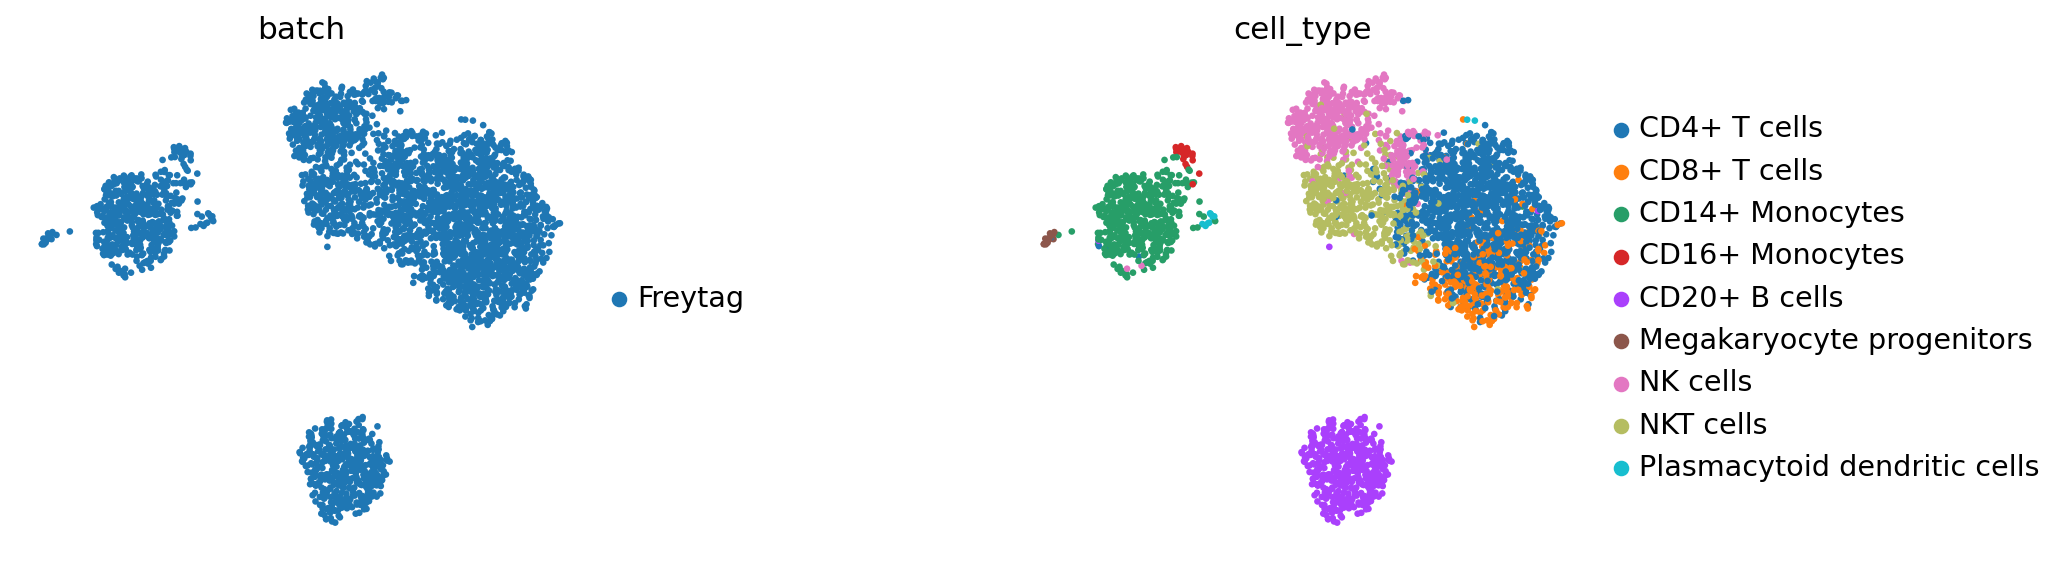

In [23]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [24]:
ref_path = 'reference_model_PBMC/'
trvae.save(ref_path, overwrite=True)

In [ ]:
#It is only adding the new task!!!!!????
list_task_i = []
new_tasks = tasks_list
for ID in range(len(new_tasks)): #adata_tasks[1:] if you wanna skip the first item, , start=1
    print('ID BEFORE:', ID)
    #ID +=1
    print('ID:', ID)
    for ID_past in range(ID):
        print('ID_past:', ID_past)
        task_i = adata_tasks[adata_tasks.obs['batch'].isin([tasks_list[ID_past],tasks_list[ID]])]
        print('adata_tasks[ID_past,ID]:', [tasks_list[ID_past],tasks_list[ID]])
        print('task_i:', task_i)
        new_trvae = sca.models.TRVAE.load_query_data(adata=task_i,
                                                     learning_approach = 'rehearsal',
                                                     model=ref_path)
        new_trvae.train(
        n_epochs=surgery_epochs,
        alpha_epoch_anneal=200,
        early_stopping_kwargs=early_stopping_kwargs,
        #ID=ID,
        weight_decay=0,
        learning_approach = 'rehearsal'
        )

        ref_path = 'reference_model/'#+ str (ID)
        new_trvae.save(ref_path, overwrite=True)
        list_task_i.append(task_i)

ID BEFORE: 0
ID: 0
ID BEFORE: 1
ID: 1
ID_past: 0
adata_tasks[ID_past,ID]: ['Oetjen_U', 'Sun_sample2_KC']
task_i: View of AnnData object with n_obs × n_vars = 6011 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.

INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 2000 128 3
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 3
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 

rehearsal is happening!
 |████----------------| 22.4%  - val_loss: 467.7416320801 - val_recon_loss: 460.4445434570 - val_kl_loss: 12.5071401596 - val_mmd_loss: 0.3556232452


 |██------------------| 10.2%  - val_loss: 497.0306030273 - val_recon_loss: 492.1168457031 - val_kl_loss: 17.8248367310 - val_mmd_loss: 0.4575511932
ADJUSTED LR
 |██------------------| 13.4%  - val_loss: 497.5569213867 - val_recon_loss: 491.4788024902 - val_kl_loss: 17.1593112946 - val_mmd_loss: 0.4155456543
ADJUSTED LR
 |███-----------------| 19.0%  - val_loss: 498.1642150879 - val_recon_loss: 490.1768310547 - val_kl_loss: 16.0794549942 - val_mmd_loss: 0.4300449371
ADJUSTED LR
 |████----------------| 20.4%  - val_loss: 504.0228027344 - val_recon_loss: 495.4319458008 - val_kl_loss: 16.1142185211 - val_mmd_loss: 0.4531791687
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 80
ID BEFORE: 4
ID: 4
ID_past: 0
adata_tasks[ID_past,ID]: ['Oetjen_U', 'Oetjen_A']
task_i: View of AnnData object with n_obs × n_var

 |█-------------------| 8.8%  - val_loss: 456.6769897461 - val_recon_loss: 451.7844543457 - val_kl_loss: 19.4885410309 - val_mmd_loss: 0.7024929047
ADJUSTED LR
 |██------------------| 10.2%  - val_loss: 469.7183288574 - val_recon_loss: 464.3953125000 - val_kl_loss: 18.8107742310 - val_mmd_loss: 0.6203205109
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 29
ID_past: 1
adata_tasks[ID_past,ID]: ['Sun_sample2_KC', 'Sun_sample1_CS']
task_i: View of AnnData object with n_obs × n_vars = 4006 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This informatio

Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.

INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 2000 128 8
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 8
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 

rehearsal is happening!
 |--------------------| 1.4%  - val_loss: 695.8544034091 - val_recon_loss: 694.1737116033 - val_kl_loss: 27.6840998910 - val_mmd_loss: 0.8501739502

In [ ]:
adata_full = source_adata.concatenate(list_task_i, batch_key="ref_query")
adata_full

In [ ]:
full_latent = sc.AnnData(new_trvae.get_latent(adata_full.X, adata_full.obs[condition_key]))
full_latent.obs['cell_type'] = adata_full.obs["final_annotation"].tolist()
full_latent.obs['batch'] = adata_full.obs["batch"].tolist()

In [ ]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
sc.pl.umap(full_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [ ]:
# surg_path = 'EWC_model_PBMC'
# new_trvae.save(surg_path, overwrite=True)

In [ ]:
elapsed_time = time.time() - st
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [ ]:
import scanpy
import scib
arches_nb_graph=sc.pp.neighbors(full_latent, n_neighbors=8, n_pcs=None, use_rep='X')
Batch_corr_graph_conn_rehearsal=scib.metrics.graph_connectivity(full_latent, 'batch')
# Bio_cons_graph_conn_rehearsal=scib.metrics.graph_connectivity(full_latent, 'cell_type')

Batch_corr_graph_conn_rehearsal #Bio_cons_graph_conn_rehearsal,
#ewc 0.4
#(0.8064201093297406, 0.96950029045287)
#Bio_cons_graph_conn_onetenth=0.9726962958482419
#Batch_corr_graph_conn_onetenth=0.9048741734427915

#Bio_cons_graph_conn_oneseven=0.9745484517119338
#Batch_corr_graph_conn_ewc_oneseven=0.900851122200876

#Bio_cons_graph_conn_justone=0.9716943944998939
#Batch_corr_graph_conn_justone=0.8986872604637476

#Bio_cons_graph_conn_rehearsal=0.9719486957484479
#Batch_corr_graph_conn_rehearsal=0.7289319302023399

#Bio_cons_graph_conn_surgery= 0.9720376251198082
#Batch_corr_graph_conn_surgery= 0.8887370544168703

#Bio_cons_graph_conn_LR= 0.9492260697382402
#Batch_corr_graph_conn_LR_1= 0.5426049544682822

#Batch_corr_graph_conn_LR_1_EWC_1= 

In [ ]:
sc.tl.umap(full_latent)
Batch_corr_ASW_rehearsal=scib.metrics.silhouette_batch(full_latent, batch_key='batch', group_key='cell_type', embed='X_umap')
Batch_corr_ASW_rehearsal
#ew 0.4
# mean silhouette per group:                       silhouette_score
# group                                 
# Pancreas Acinar               0.736741
# Pancreas Alpha                0.770816
# Pancreas Beta                 0.781566
# Pancreas Delta                0.796581
# Pancreas Ductal               0.822017
# Pancreas Endothelial          0.687825
# Pancreas Gamma                0.768996
# Pancreas Stellate             0.759653
# 0.7655244790288251
#Batch_corr_ASW_onetenth=0.7700163313882914
#Batch_corr_ASW_oneseven=0.7677420977118364
#Batch_corr_ASW_justone=0.7864891512875769
#Batch_corr_ASW_rehearsal=0.8056815952195894
#Batch_corr_ASW_surgery= 0.7842399695236884
#Batch_corr_ASW_LR_1= 0.6784535513509236
#Batch_corr_ASW_LR_1_EWC_1=

In [ ]:
Bio_cons_ASW_rehearsal=scib.metrics.silhouette(full_latent, group_key='cell_type', embed='X_umap')
Bio_cons_ASW_rehearsal
#ewc 0.4
# 0.6053410544991493
#Bio_cons_ASW_onetenth=0.6302791982889175
#Bio_cons_ASW_oneseven=0.6242425590753555
#Bio_cons_ASW_justone=0.6405854225158691
#Bio_cons_ASW_rehearsal=0.6806580275297165
#Bio_cons_ASW_surgery= 0.6246893554925919
#Bio_cons_ASW_LR_1= 0.6391573995351791
#Bio_cons_ASW_LR_1_EWC_1=

In [ ]:
isolated_labels_rehearsal=scib.metrics.isolated_labels(full_latent, label_key='cell_type', batch_key='batch', embed='X_umap')
isolated_labels_rehearsal
#ewc 0.4
# Pancreas Acinar: 0.6085918854415274
# Pancreas Alpha: 0.9658803706823925
# Pancreas Beta: 0.840328569821087
# Pancreas Delta: 0.9542857142857143
# Pancreas Ductal: 0.8173030449492509
# Pancreas Endothelial: 0.7357575757575758
# Pancreas Gamma: 0.9332333083270817
# Pancreas Stellate: 0.8173147468818782
#isolated_labels_onetenth=0.8439304117951834
#isolated_labels_oneseven = 0.8430725908139767
#isolated_labels_justone=0.8312470266054668
#isolated_labels_rehearsal=0.8493131710683232
#isolated_labels_surgery= 0.8426657377460711
#isolated_labels_LR_1= 0.92
#isolated_labels_LR_1_EWC_1= 

In [ ]:
pcr_justone=scib.metrics.pcr_comparison(source_adata, adata, covariate='batch', embed=None, n_comps=50, scale=False, verbose=False)
pcr_justone
# pcr_justone=scib.metrics.pcr_comparison(source_adata, adata, covariate, embed=None, n_comps=50, scale=True, verbose=False)
#pcr_oneseven=0.02870146673652502
#pcr_onetenth=0.02870146673652502
#pcr_surgery= 0.028701497023668674
#pcr_LR_1= 0.03145006004231193
#pcr_LR_1_EWC_1= 